In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.stats import rankdata
import matplotlib.colors as mcolors
import itertools as it
import functools as ft
import dataclasses
from typing import NamedTuple
from math import cos, sin

In [2]:
%matplotlib widget

In [3]:
sns.set()

In [59]:
slope = 2.0
size = 1000
x = np.random.normal(size=size)
y = slope * x  + np.random.normal(size=size)
y = (y - np.mean(y)) / np.std(y)

In [60]:
x_mean, y_mean = np.mean(x), np.mean(y)

In [49]:
cov = np.cov(x, y)

In [7]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [8]:
def rotate(x: np.ndarray, theta) -> np.ndarray:
    rotate_matrix = np.array(
        [
            [cos(theta), -sin(theta)], 
            [sin(theta),  cos(theta)]
        ]
    )
    return rotate_matrix @ x
    

In [9]:
class InteractiveScatter:
    """Plot the evolution of the 2D EM algorithm"""

    def __init__(self, ax, size, cov):
        self.ax = ax
        self.cov = cov
        self.size = size
        self.x = np.random.normal(scale=0.1, size=size)
        self.y = slope * self.x + np.random.normal(size=size)
        self.y = (self.y - np.mean(self.y)) / np.std(self.y)
        
    def plot(self, theta):
        self.ax.clear()
        x, y = rotate(np.vstack((self.x, self.y)), np.radians(theta))
        
        # y = normalize(y)
        data = self.cov @ np.vstack((x, y))
        self.ax.set_ylim(-10, 10)
        self.ax.set_xlim(-10, 10)
        
        self.ax.scatter(x, y, label='no transform')
        self.ax.scatter(*data, label='yes transform')
        plt.legend()
        


In [51]:
cov

array([[1.02033487, 0.91458842],
       [0.91458842, 1.001001  ]])

In [54]:
eva, eve = np.linalg.eig(cov)

In [55]:
eve

array([[ 0.71083371, -0.70336011],
       [ 0.70336011,  0.71083371]])

In [67]:
eva

array([1.92530744, 0.09602843])

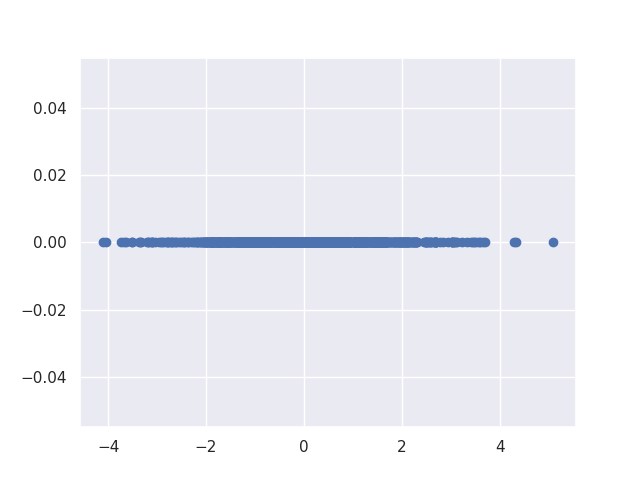

In [75]:
projected = eve[:, 0][np.newaxis, :] @ np.vstack((x, y))
plt.figure()
plt.scatter(projected, np.zeros_like(projected))
plt.show()

In [78]:
xe, ye = eve.T @ np.vstack((x, y))

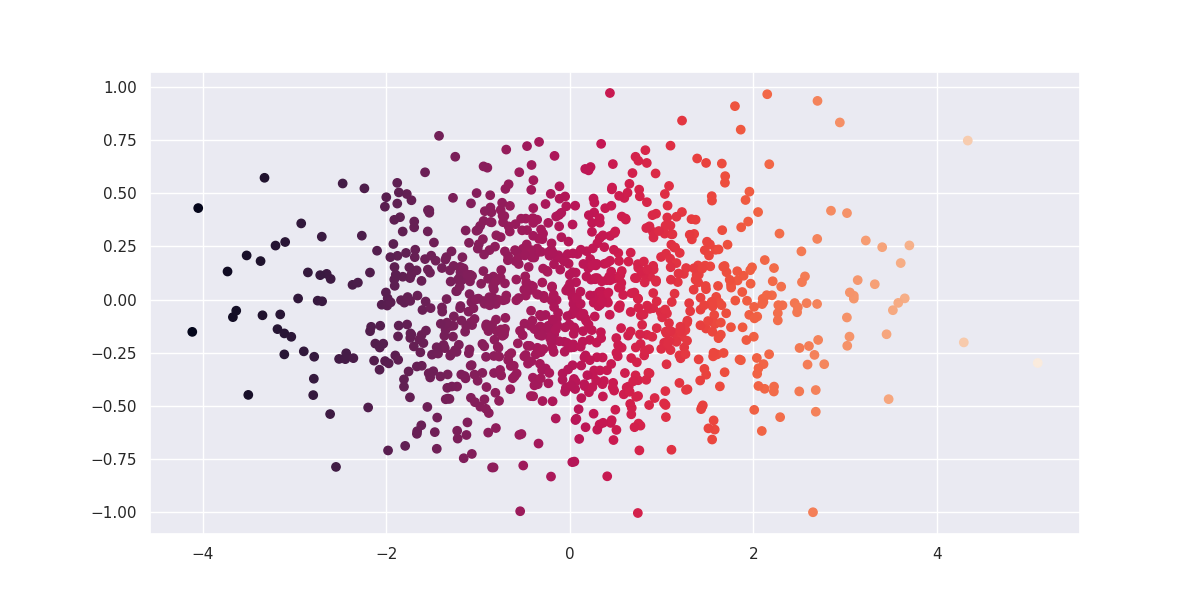

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.scatter(xe, ye, c=x+y)

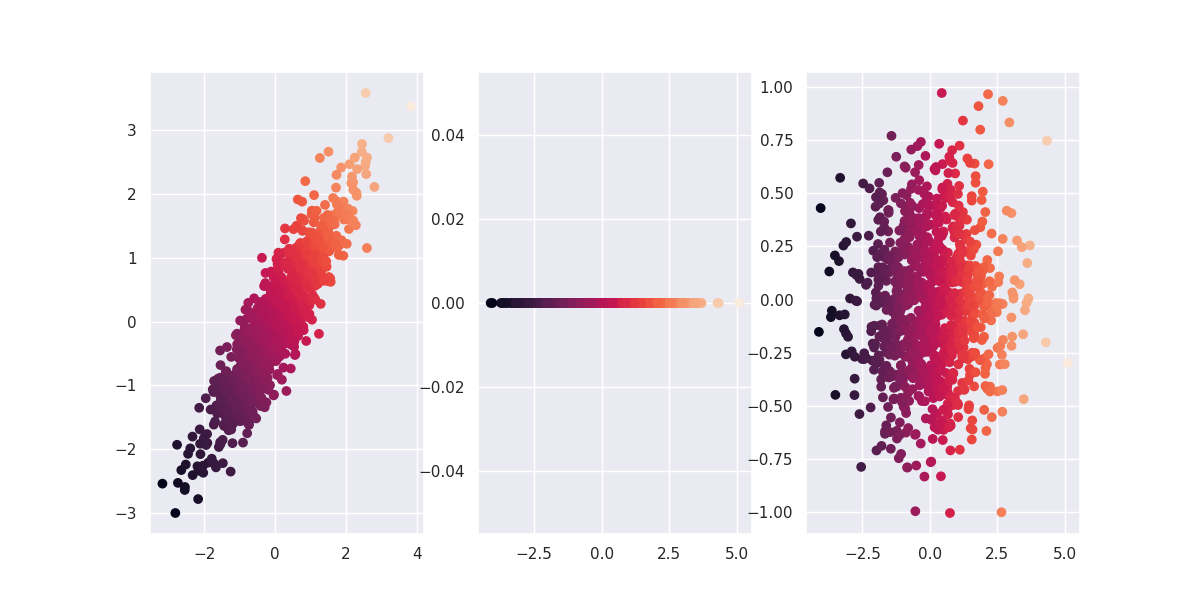

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(x, y, c=x+y)
ax2.scatter(projected, np.zeros_like(projected), c=x+y)
ax3.scatter(xe, ye, c=x+y)
# plt.scatter(xe, ye)

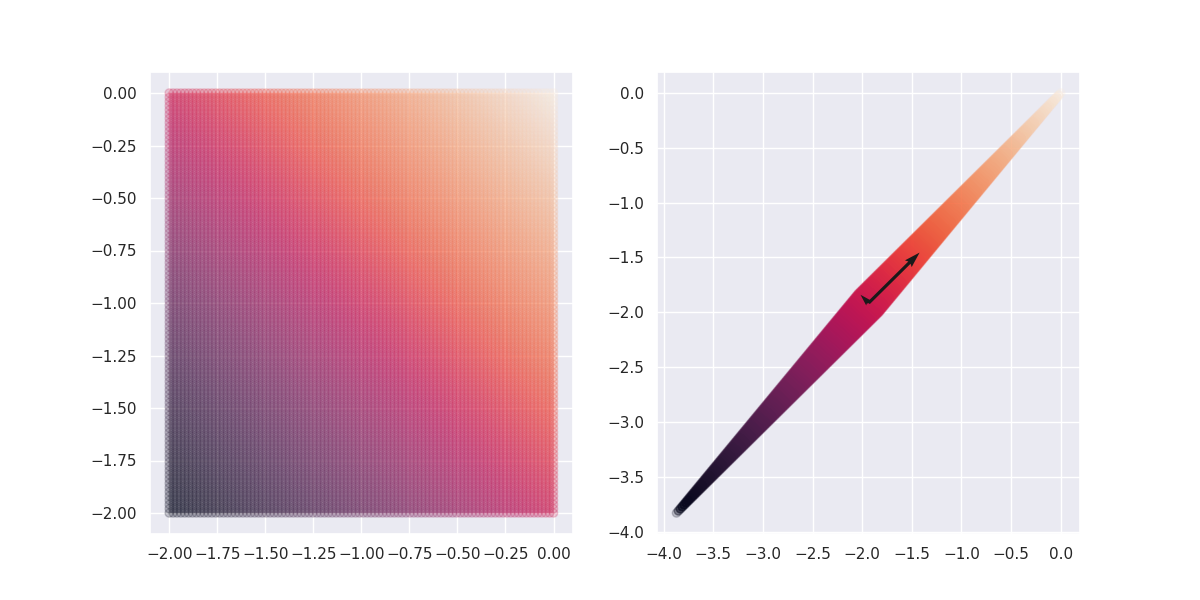

In [86]:
x, y = np.linspace(-2, 0, 100), np.linspace(-2, 0, 100)
x, y = np.meshgrid(x, y)
x, y = np.stack((x, y), axis=-1).reshape((-1, 2)).T
xc, yc = cov @ np.vstack((x, y))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(x, y, c=x+y, alpha=0.2)
ax2.scatter(xc, yc, c=x+y, alpha=0.2)
mxc, myc = np.mean(xc), np.mean(yc)
ax2.quiver([mxc, mxc], [myc, myc], *eve, units="xy", scale=10*np.exp(eva[::-1]) / np.exp(eva.sum()))

interactive(children=(FloatSlider(value=180.0, description='theta', max=360.0, step=0.001), Output()), _dom_cl…

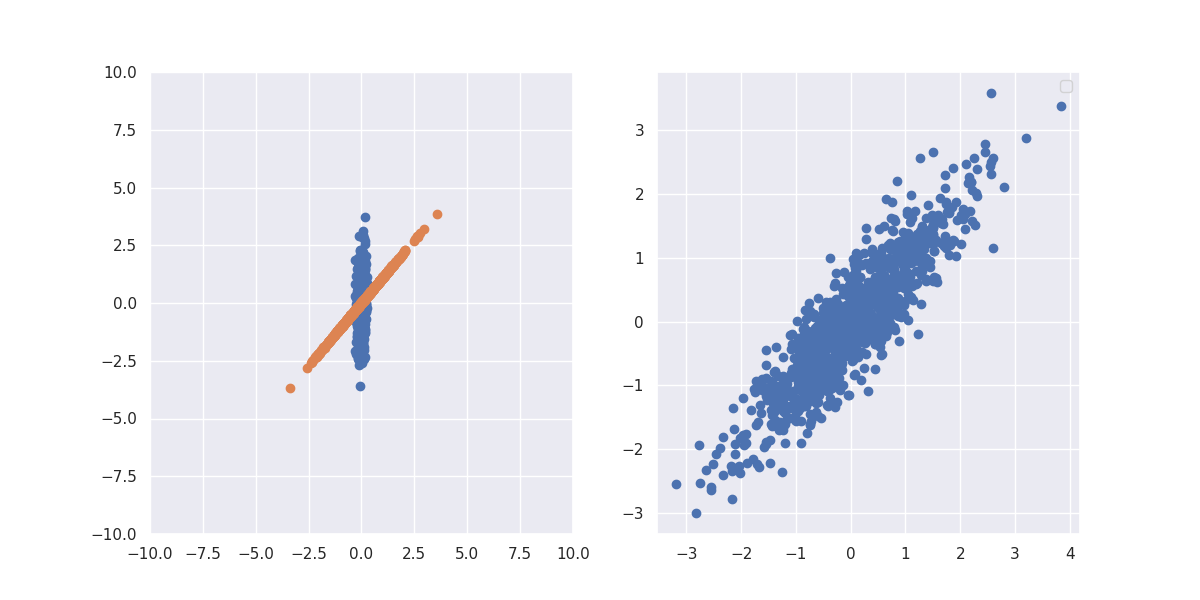

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
interactive_scatter = InteractiveScatter(ax1, 1000, cov)
ax2.scatter(x, y)
_ = widgets.interact(interactive_scatter.plot, theta=(0, 360, 0.001))
                       

In [393]:
x_cov, y_cov, x_cov + y_cov

(array([0.08358375, 0.16919395]),
 array([0.16919395, 1.38778427]),
 array([0.2527777 , 1.55697822]))

In [394]:
eva

array([1.92789523, 0.10199515])

In [395]:

v0 = eve[:, 1]

In [396]:
v0[1] / v0[0]

-1.0153922173613528

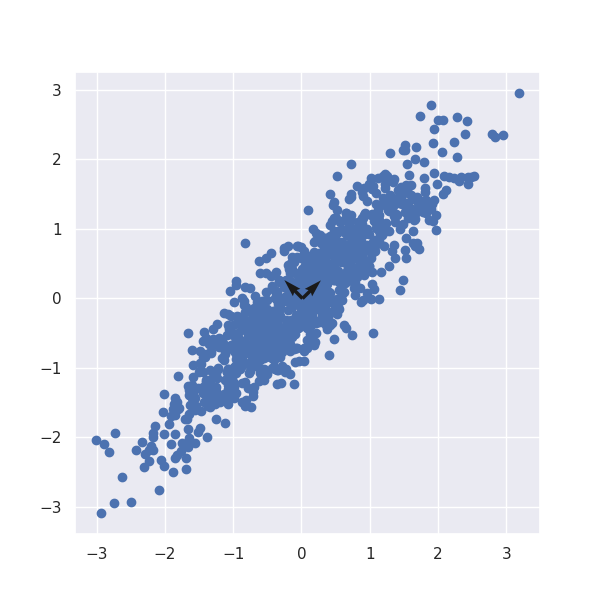

In [397]:
ig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x, y)
# ax.quiver(x_mean, y_mean, *x_cov)
# ax.quiver(x_mean, y_mean, *y_cov)
# ax.quiver(x_mean, y_mean, *(x_cov + y_cov))
ax.quiver(x_mean, y_mean, *(5 * eve[:, 0]))
ax.quiver(x_mean, y_mean, *(5 * eve[:, 1]))


plt.show()

In [208]:
cov

array([[0.08358375, 0.0817798 ],
       [0.0817798 , 0.08011123]])

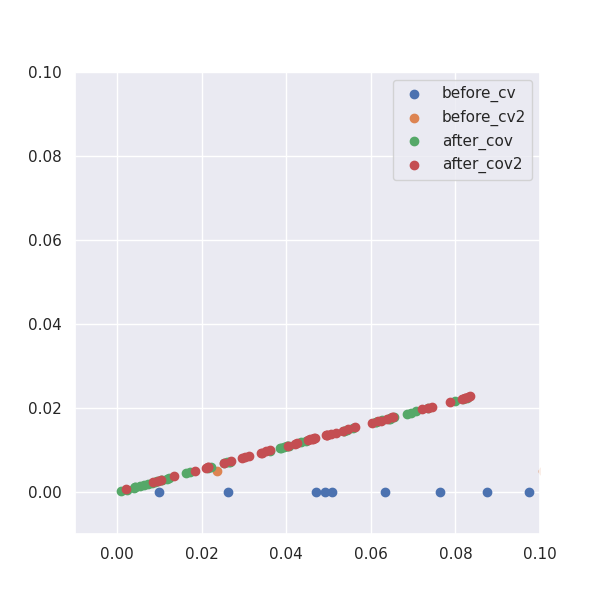

In [256]:
cov = np.cov(x, y)
before_cov = np.vstack((np.random.rand(50), np.zeros(50)))
before_cov2 = np.vstack((np.random.rand(50), 0.005 + np.zeros(50)))
after_cov = cov @  before_cov
after_cov2 = cov @  before_cov2

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*before_cov, label="before_cv")
a = ax.scatter(*before_cov2, label="before_cv2")
ax.scatter(*after_cov, label="after_cov")
ax.scatter(*after_cov2, label="after_cov2")
ax.set_ylim(-0.01, 0.1)
ax.set_xlim(-0.01, 0.1)
plt.legend()
plt.show()

